In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [3]:
import sys, os
import glob
import warnings
from itertools import cycle
sys.path.append('../')

from rankutils.evaluation import comp_precision, comp_recall, interp_prec_recall_curve

from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook
import mpld3
#sns.set()

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

np.set_printoptions(suppress=True, precision=3, linewidth=300, formatter=dict(float="{0:0.4f}"))

In [4]:
def eval_elp_precision_recall(labels, k):
    
    assert labels.shape[1] >= k, "The number of positions labeled for each rank <{0:d}> should be >= k <{1:d}>".format(labels.shape[1], k)
    
    elp_rec = np.arange(0.0, 1.1, 0.1)
    elp_prec_all = []
    ap_all = np.zeros(labels.shape[0], dtype=np.float64)

    for i, row in enumerate(labels):
        
        y_true = row[0:k]
        
        if y_true.sum() > 0:

            prec = comp_precision(y_true)
            rec = comp_recall(y_true)

            elp_prec_all.append(interp_prec_recall_curve(prec, rec, points=elp_rec))

            ap_all[i] = average_precision_score(y_true, np.arange(y_true.size, 0, -1))
        else:
            aux = np.zeros(11, dtype=np.float64)
            aux[0] = 1.0
            elp_prec_all.append(aux)

    elp_prec_all = np.vstack(elp_prec_all)

    mean_elp_prec = np.mean(elp_prec_all, axis=0)
    
    return mean_elp_prec, np.mean(ap_all), ap_all

In [5]:
def load_pathlists(collection, get_bsl=[]):
    
    # Baseline Labels
    bsl_labeldir = '/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-labels/2x5-fold/{0:s}/'.format(collection)
    aux = glob.glob(bsl_labeldir + "*.npy")
    aux.sort()
    if get_bsl:
        bsl_labelpaths = []
        for i in get_bsl:
            bsl_labelpaths.append(aux[i])
    else:
        bsl_labelpaths = aux

    # Aggregated Labels
    agg_labeldir = '/home/alberto/phD/projects/performance_prediction/ret-mr-learning/output-agg/eval/'.format(collection)
    agg_labelpaths = glob.glob(agg_labeldir + "*.npz")
    agg_labelpaths.sort()
    
    return bsl_labelpaths, agg_labelpaths

In [6]:
topk = 30
collection = 'imagenet'

leg_name_map = dict()

bsl_labelpaths, agg_labelpaths = load_pathlists(collection)

np.set_printoptions(precision=3, suppress=True)

In [7]:
bsl_namelist = [[], []]
bsl_eval = [[], []]

min_mAP = np.inf
max_mAP = -np.inf

ap_all_list = []

# Evaluating the baselines. Retains only the methods with max and min mAP
for path in tqdm(bsl_labelpaths, desc="Evaluating baselines: ", total=len(bsl_labelpaths)):
    
    mean_elp_prec, mAP, ap_all = eval_elp_precision_recall(np.load(path), topk)
    ap_all_list.append(ap_all.reshape(-1, 1))
    
    if mAP < min_mAP:
        bsl_eval[0] = mean_elp_prec
        aux = os.path.basename(path).rsplit('.', 2)[0]
        bsl_namelist[0] = "{0:70s} : mAP = {1:0.3f}".format(aux, mAP)
        min_mAP = mAP
    
    if mAP > max_mAP:
        bsl_eval[1] = mean_elp_prec
        aux = os.path.basename(path).rsplit('.', 2)[0]
        bsl_namelist[1] = "{0:70s} : mAP = {1:0.3f}".format(aux, mAP)
        max_mAP = mAP

In [8]:
# bsl_namelist = []
# bsl_eval = []

# min_mAP = np.inf
# max_mAP = -np.inf

# ap_all_list = []


# for path in tqdm(bsl_labelpaths, desc="Evaluating baselines: ", total=len(bsl_labelpaths)):
    
#     mean_elp_prec, mAP, ap_all = eval_elp_precision_recall(np.load(path), topk)
#     ap_all_list.append(ap_all.reshape(-1, 1))
    
#     bsl_eval.append(mean_elp_prec)
#     aux = os.path.basename(path).rsplit('.', 2)[0]
#     bsl_namelist.append("{0:70s} : mAP = {1:0.3f}".format(aux, mAP))

In [9]:
agg_namelist = []
agg_eval = []

for path in tqdm(agg_labelpaths, desc="Evaluating additionals: ", total=len(agg_labelpaths)):
    
    try:
        mean_elp_prec, mAP, ap_all = eval_elp_precision_recall(np.load(path)['labels'], topk)
        agg_eval.append(mean_elp_prec)
        ap_all_list.append(ap_all.reshape(-1, 1))

        aux = os.path.basename(path).rsplit('.', 1)[0]
        agg_namelist.append("{0:70s} : mAP = {1:0.3f}".format(aux, mAP))
    except AssertionError:
        pass

imagenet.004.resnetv2-Canb                                             : mAP = 0.852
imagenet.001.resnetv2-L2sq                                             : mAP = 0.876
imagenet.combMIN.n500                                                  : mAP = 0.866
imagenet.combMIN_avgw.n30k30.f100.pred0009                             : mAP = 0.891
imagenet.combSUM.n500                                                  : mAP = 0.867
imagenet.combSUM_pre.n30k30.f100.pred0009                              : mAP = 0.892


<IPython.core.display.Javascript object>


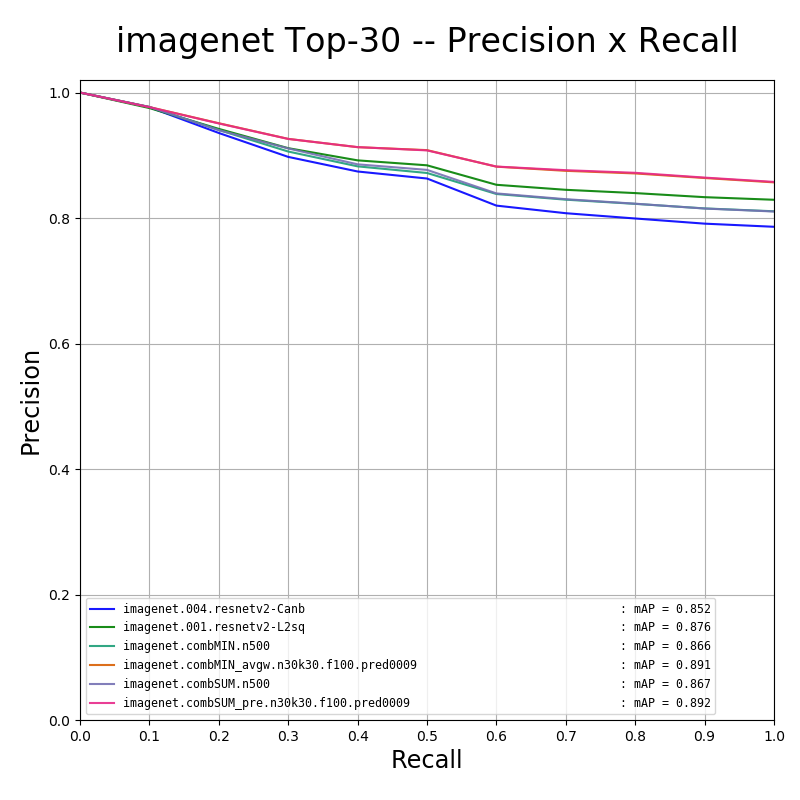

In [12]:
for n in bsl_namelist:
    print(n)
    
for n in agg_namelist:
    print(n)

# changing the legend entry order
#order = [0, 7, 1, 5, 4, 3, 2, 6]
order = range(len(agg_namelist))
    
    
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
fig.tight_layout()

x = np.arange(0.0, 1.1, 0.1)

# Drawing Baselines

ax.plot(x, bsl_eval[0], '-', color='blue', label="{0:50s}".format(bsl_namelist[0]), alpha=0.9)
ax.plot(x, bsl_eval[1], '-', color='green', label="{0:50s}".format(bsl_namelist[1]), alpha=0.9)

c = plt.get_cmap('Dark2')
for i in order:
    y = agg_eval[i]
    
    if agg_namelist[i] in leg_name_map:
        l = leg_name_map[agg_namelist[i]]
    else:
        l = agg_namelist[i]
    
    ax.plot(x, y, '-', color=c(i), label="{0:50s}".format(l), alpha=0.9)


ax.set_xlim(0.0, 1.0)
ax.set_xlabel('Recall', **dict(fontsize='xx-large'))
ax.set_xticks(np.arange(0.0, 1.1, 0.1))

ax.set_ylim(0.0, 1.02)
ax.set_ylabel('Precision', **dict(fontsize='xx-large'))

ax.grid(which='both', axis='both')

ax.set_title('{0:s} Top-{1:d} -- Precision x Recall'.format(collection, topk), **dict(fontsize=24), pad=20)

legend = ax.legend(prop={'family':'monospace', 'size':'small'})

plt.subplots_adjust(left=0.1, top=0.9, bottom=0.1)
#mpld3.enable_notebook()
#plt.savefig('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/misc./{0:s}_top{1:d}_PxR.svg'.format(collection, topk))

In [11]:
# def print_ap_all(ap_all_arr):
    
#     count = 0
#     print("idx           baselines                     aggr")
#     for i, row in enumerate(ap_all_arr):
#         if row[5] < 0.9*np.min(row[0:5]):
#             print("{0:04d}".format(i), "   ", row[0:5], "   ", row[5:])
#             count += 1
            
#     print("Total:",count)

# print_ap_all(np.hstack(ap_all_list))